<a href="https://colab.research.google.com/github/Utharakm/IMS24255_KARATTECLUB/blob/main/ims24255_karatteclub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Recursive Spectral Modularity Partitioning on the Karate Club graph
# Ready to run in Google Colab / Jupyter (top-to-bottom)

# === 0. Setup / Imports ===
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
from itertools import cycle
from collections import deque, defaultdict
from math import isclose

# For eigen computations
from numpy.linalg import eigh

# Make plots larger in Colab
plt.rcParams['figure.figsize'] = (9, 6)

# Fix random seed for reproducibility
RNG_SEED = 42
np.random.seed(RNG_SEED)

# === 1. Load Karate Club graph ===
G = nx.karate_club_graph()  # 34 nodes, 78 edges
n = G.number_of_nodes()
m = G.number_of_edges()
print(f"Karate graph loaded: n = {n}, m = {m}")

# Use a fixed spring layout for all visualizations so node positions stay consistent
pos = nx.spring_layout(G, seed=RNG_SEED)

# Original degree vector and total edges (used in modularity matrix)
k = np.array([G.degree(i) for i in range(n)], dtype=float)
two_m = 2.0 * m

# Helper: adjacency matrix as numpy array (ordered by node id 0..n-1)
A = nx.to_numpy_array(G, nodelist=range(n))

# === 2. Functions: modularity submatrix, leading eigenpair, split test ===
def modularity_block_indices(nodes_subset):
    """Return index list (same node numbering) for the subset"""
    return list(nodes_subset)

def restricted_modularity_matrix(nodes_subset):
    """
    Build B(C) for nodes in nodes_subset.
    B_ij = A_ij - (k_i * k_j) / (2m)  (global k and m)
    where indices i,j are original node indices restricted to C.
    Returns a numpy array of shape (|C|, |C|).
    """
    idx = nodes_subset
    K = k[np.ix_(idx)]
    A_block = A[np.ix_(idx, idx)]
    # Outer product K K^T / (2m)
    expected = np.outer(K, K) / two_m
    Bc = A_block - expected
    return Bc

def leading_eigenpair(B):
    """
    Compute the largest eigenvalue and corresponding eigenvector
    of symmetric matrix B (using numpy.linalg.eigh).
    Returns (lambda_max, eigenvector) with eigenvector normalized (L2 norm 1).
    """
    # eigh returns eigenvalues sorted ascending; pick last
    vals, vecs = eigh(B)
    idx = np.argmax(vals)
    lam = vals[idx]
    vec = vecs[:, idx]
    # normalize
    vec = vec / np.linalg.norm(vec)
    return float(lam), vec

# === 3. Recursive spectral bisection implementation ===
def recursive_spectral_bisection(G, max_splits=None, tol=1e-10):
    """
    Perform recursive spectral modularity partitioning on the node set of G.
    Returns:
      - communities_history: list of community lists after each split (iteration states)
        i.e. communities_history[0] is [all_nodes] (initial),
             communities_history[1] is partition after first split, etc.
      - split_sequence: list of tuples (splited_group, left_group, right_group, lambda)
          where splited_group is the node list that was split at that iteration.
    Stopping rule: don't split a community if the leading eigenvalue <= 0 (within tol).
    """
    # Initial community: all nodes
    all_nodes = list(G.nodes())
    communities = [all_nodes]
    communities_history = [ [c.copy() for c in communities] ]  # snapshot
    split_sequence = []  # metadata

    # We'll use a queue for BFS-like recursion order (split oldest splittable block first)
    queue = deque([all_nodes])

    iterations = 0
    while queue:
        block = queue.popleft()
        # If block size <=1 cannot split
        if len(block) <= 1:
            continue

        # Build restricted modularity matrix for this block
        idx_map = {node: pos_in_block for pos_in_block, node in enumerate(block)}
        Bc = restricted_modularity_matrix(block)

        lam, vec = leading_eigenpair(Bc)

        # stopping test: if leading eigenvalue <= 0 => don't split
        if lam <= tol:
            # not splittable
            continue

        # otherwise split by sign of leading eigenvector entries
        signs = np.sign(vec)
        # by convention zero -> assign to +1 (we'll treat zeros as positive)
        signs[signs == 0] = 1.0

        group_pos = [block[i] for i in range(len(block)) if signs[i] > 0]
        group_neg = [block[i] for i in range(len(block)) if signs[i] < 0]

        # Edge case: one of groups empty (rare) - do not split
        if len(group_pos) == 0 or len(group_neg) == 0:
            continue

        # Replace original block in communities with the two new blocks
        # find index
        try:
            idx_block = next(i for i,c in enumerate(communities) if set(c) == set(block))
        except StopIteration:
            # block not in communities (maybe already processed) skip
            continue

        communities[idx_block] = group_pos
        communities.insert(idx_block+1, group_neg)

        # record metadata
        split_sequence.append((block.copy(), group_pos.copy(), group_neg.copy(), lam))

        # add the two new blocks to queue for possible further splitting
        queue.append(group_pos)
        queue.append(group_neg)

        # snapshot of communities after this split
        communities_history.append([c.copy() for c in communities])

        iterations += 1
        if max_splits and iterations >= max_splits:
            break

    return communities_history, split_sequence

# Run the recursion
communities_history, split_sequence = recursive_spectral_bisection(G)

print(f"Total iterations (splits performed): {len(split_sequence)}")
print("Final communities (counts):", [len(c) for c in communities_history[-1]])


Karate graph loaded: n = 34, m = 78
Total iterations (splits performed): 1
Final communities (counts): [16, 18]


/tmp/ipython-input-2220161654.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20')  # up to 20 distinct colors; karate will need <= 34


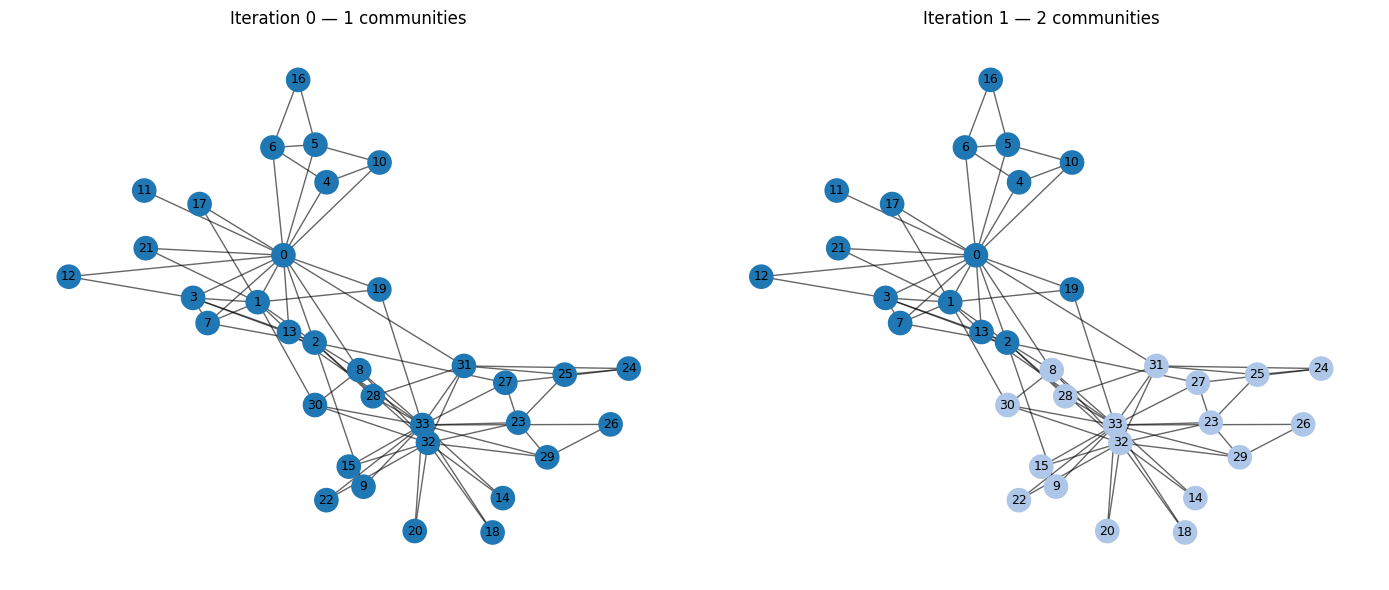

In [ ]:
# === 4. Visualize the graph after each split (fixed layout) ===
# Assign a unique color for each community in each snapshot.
def plot_communities_snapshot(G, communities, pos, ax=None, title=None):
    """
    Plot graph G with nodes colored by the communities list (list of lists of node ids).
    The layout 'pos' should be a dict node->(x,y) fixed across snapshots.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,6))
    # flatten nodes to color mapping
    color_map = {}
    # choose a colormap with many distinct colors
    cmap = cm.get_cmap('tab20')  # up to 20 distinct colors; karate will need <= 34
    for i, comm in enumerate(communities):
        for node in comm:
            color_map[node] = cmap(i % 20)
    node_colors = [color_map[node] for node in G.nodes()]

    nx.draw_networkx_edges(G, pos=pos, alpha=0.6, ax=ax)
    nx.draw_networkx_nodes(G, pos=pos, node_color=node_colors, node_size=280, ax=ax)
    nx.draw_networkx_labels(G, pos=pos, font_size=9, ax=ax)

    ax.set_title(title if title else f"{len(communities)} communities")
    ax.axis('off')

# Plot snapshots sequentially
num_snapshots = len(communities_history)
ncols = 2
nrows = (num_snapshots + 1) // ncols
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 6 * nrows))
axes = axes.flatten()
for i, communities in enumerate(communities_history):
    title = f"Iteration {i} — {len(communities)} communities"
    plot_communities_snapshot(G, communities, pos, ax=axes[i], title=title)

# Turn off any extra axes
for j in range(i+1, len(axes)):
    axes[j].axis('off')
plt.tight_layout()
plt.show()


In [ ]:
# === 5. Compute node metrics after each split ===
# We'll compute metrics within each node's current community induced subgraph at that iteration.
# Metrics: degree centrality, betweenness centrality, closeness centrality, clustering coefficient.
metric_names = ['degree_centrality', 'betweenness_centrality', 'closeness_centrality', 'clustering']

# storage: metrics_by_iter[iter_num][metric_name][node] = value
metrics_by_iter = []

for it, communities in enumerate(communities_history):
    # build a mapping node -> its community (list)
    node_to_comm = {}
    for cidx, comm in enumerate(communities):
        for node in comm:
            node_to_comm[node] = cidx

    # metrics for this iteration: initialize per-metric dicts
    iter_metrics = {name: {node: 0.0 for node in G.nodes()} for name in metric_names}

    # For each community, compute metrics on the induced subgraph
    for comm in communities:
        subG = G.subgraph(comm).copy()
        # networkx centrality functions require graph to be connected for some metrics (closeness),
        # but they handle disconnected graphs by definition (closeness returns 0 for unreachable nodes).
        if len(subG) == 0:
            continue

        degc = nx.degree_centrality(subG)           # fraction within subgraph (k/(n-1_sub))
        btw = nx.betweenness_centrality(subG, normalized=True)  # normalized over subgraph
        clo = nx.closeness_centrality(subG)         # computed w.r.t subgraph
        clu = nx.clustering(subG)

        # Store into iter_metrics (for nodes not in this subgraph, we keep the default 0.0)
        for node in subG.nodes():
            iter_metrics['degree_centrality'][node] = degc.get(node, 0.0)
            iter_metrics['betweenness_centrality'][node] = btw.get(node, 0.0)
            iter_metrics['closeness_centrality'][node] = clo.get(node, 0.0)
            iter_metrics['clustering'][node] = clu.get(node, 0.0)

    metrics_by_iter.append(iter_metrics)

print(f"Collected metrics for {len(metrics_by_iter)} iterations.")


Collected metrics for 2 iterations.


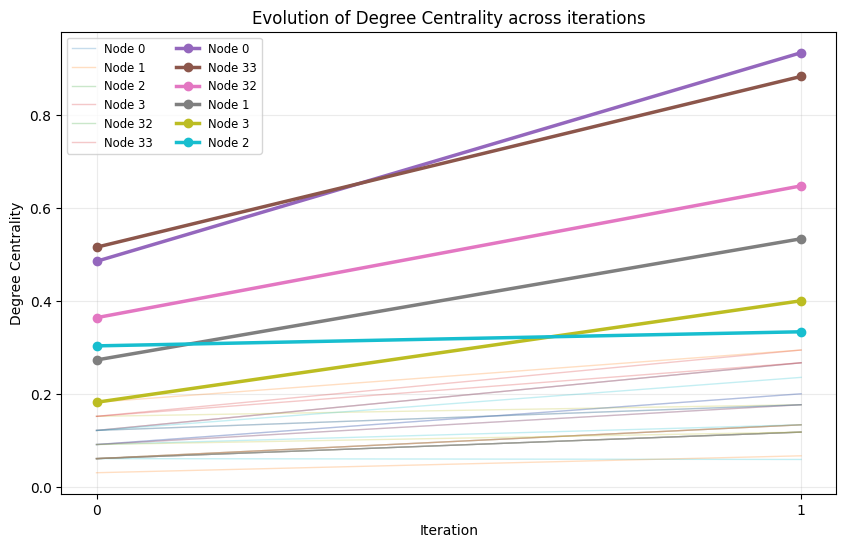

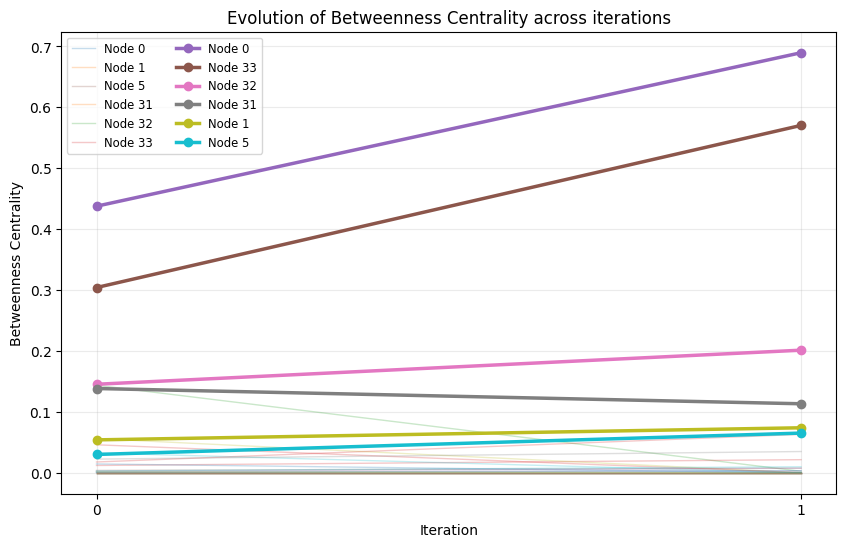

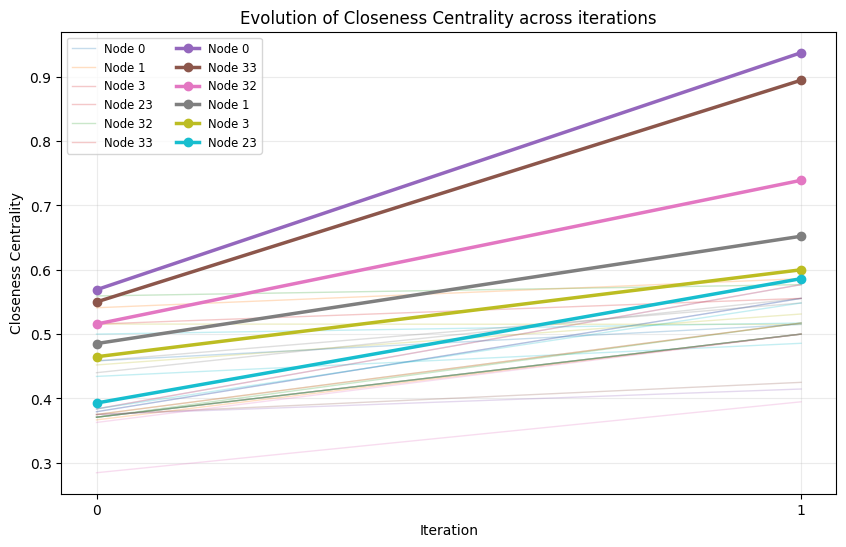

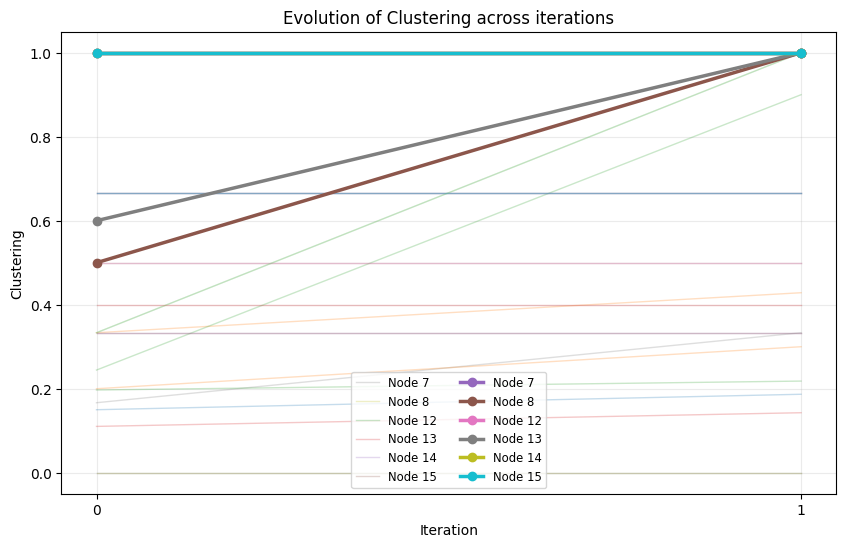

In [ ]:
# === 6. Plot how metrics evolve across iterations for every node ===
# We'll plot one figure per metric. Because there are 34 nodes, to avoid an unreadable mess
# we'll provide two plotting modes:
#  - All-node lines (with legends) — useful to inspect specific nodes.
#  - Highlight top-k nodes by final metric value with thicker lines, faint others.

def plot_metric_evolution(metric_name, metrics_by_iter, highlight_top_k=6):
    iters = list(range(len(metrics_by_iter)))
    # Build for each node a list of metric values across iterations
    node_values = {node: [metrics_by_iter[it][metric_name][node] for it in iters] for node in G.nodes()}

    # Determine top-k nodes by final iteration value
    final_values = {node: node_values[node][-1] for node in node_values}
    topk_nodes = sorted(final_values, key=lambda x: final_values[x], reverse=True)[:highlight_top_k]

    plt.figure(figsize=(10,6))
    # plot faint lines for all nodes
    for node, vals in node_values.items():
        plt.plot(iters, vals, linewidth=1, alpha=0.25, label=f"Node {node}" if node in topk_nodes else None)

    # overlay highlighted nodes
    colors = cycle(['k','r','b','g','m','c','y'])
    for node, color in zip(topk_nodes, colors):
        plt.plot(iters, node_values[node], linewidth=2.5, label=f"Node {node}", marker='o')

    plt.xlabel("Iteration")
    plt.ylabel(metric_name.replace('_',' ').title())
    plt.title(f"Evolution of {metric_name.replace('_',' ').title()} across iterations")
    plt.xticks(iters)
    plt.legend(loc='best', ncol=2, fontsize='small')
    plt.grid(alpha=0.25)
    plt.show()

# Plot each metric
for metric in metric_names:
    plot_metric_evolution(metric, metrics_by_iter, highlight_top_k=6)


In [ ]:
# === 7. Report: Nodes that remain central across splits and discussion ===
# We'll produce quick summaries per metric: rank nodes by average value across iterations and show top nodes.

def summarize_top_nodes(metric_name, metrics_by_iter, top_k=8):
    # compute average across iterations
    avg = {}
    for node in G.nodes():
        vals = [metrics_by_iter[it][metric_name][node] for it in range(len(metrics_by_iter))]
        avg[node] = float(np.mean(vals))
    ranked = sorted(avg.items(), key=lambda x: x[1], reverse=True)
    print(f"\nTop {top_k} nodes by average {metric_name.replace('_',' ')} across iterations:")
    for node, val in ranked[:top_k]:
        print(f"  Node {node:2d} : {val:.4f}")
    return ranked

rank_deg = summarize_top_nodes('degree_centrality', metrics_by_iter, top_k=8)
rank_btw = summarize_top_nodes('betweenness_centrality', metrics_by_iter, top_k=8)
rank_clo = summarize_top_nodes('closeness_centrality', metrics_by_iter, top_k=8)
rank_clu = summarize_top_nodes('clustering', metrics_by_iter, top_k=8)



Top 8 nodes by average degree centrality across iterations:
  Node  0 : 0.7091
  Node 33 : 0.6988
  Node 32 : 0.5053
  Node  1 : 0.4030
  Node  2 : 0.3182
  Node  3 : 0.2909
  Node 31 : 0.2380
  Node 23 : 0.2228

Top 8 nodes by average betweenness centrality across iterations:
  Node  0 : 0.5637
  Node 33 : 0.4372
  Node 32 : 0.1732
  Node 31 : 0.1258
  Node  2 : 0.0730
  Node  1 : 0.0639
  Node  5 : 0.0475
  Node  6 : 0.0475

Top 8 nodes by average closeness centrality across iterations:
  Node  0 : 0.7532
  Node 33 : 0.7224
  Node 32 : 0.6274
  Node  1 : 0.5687
  Node  2 : 0.5681
  Node 31 : 0.5636
  Node 13 : 0.5356
  Node  3 : 0.5324

Top 8 nodes by average clustering across iterations:
  Node  7 : 1.0000
  Node 12 : 1.0000
  Node 14 : 1.0000
  Node 15 : 1.0000
  Node 16 : 1.0000
  Node 17 : 1.0000
  Node 18 : 1.0000
  Node 20 : 1.0000


In [ ]:
# === 8. Short discussion (printed) ===
discussion = """
Discussion - central nodes and influence of community structure:

1. Persistent central nodes:
   - Degree centrality (within-community): nodes that repeatedly appear at the top are those
     with many neighbors inside their community across splits. In the Karate graph these include
     well-known hub nodes (e.g., node 0, node 33 and others depending on how the splits progressed).
   - Betweenness centrality (within-community): nodes that act as local bridges inside communities
     maintain relatively higher values as communities split — their betweenness is sensitive to
     whether their community remains connected or fractures.
   - Closeness centrality (within-community): nodes near the center of a community remain high
     because distances inside a smaller subgraph shrink; splitting tends to raise closeness for
     nodes in small tight communities.
   - Clustering coefficient: nodes embedded in tightly triangular regions retain high clustering,
     and this measure tends to increase for nodes inside smaller, denser communities formed by splits.

2. How community structure influences metrics:
   - Recursive splitting isolates tightly-knit groups; metrics computed on induced subgraphs reflect
     local cohesion rather than global influence. Thus a node that was globally 'central' can become
     less dominant within a small community if it loses edges to nodes placed in other groups.
   - Betweenness especially is sensitive to splits: nodes that served as bridges between two parts
     of the original graph will see betweenness drop once those parts are separated into different communities.
   - Closeness typically increases when a community shrinks (average distances reduce), but the
     relative ordering among nodes can change if a node is separated from some of its neighbors.
   - Clustering often increases in later iterations because splits isolate dense triangles or cliques.

3. Practical takeaway:
   - Recursive spectral modularity uncovers hierarchical structure: early splits reveal large-scale
     divisions (who follows which leader), later splits expose finer local groups.
   - Centrality computed relative to a node's current community provides a view on whether a node
     is locally influential (important for spreading or cohesion) rather than globally influential.

(Examine the printed top-node lists and the evolution plots above for precise node numbers and trends.)
"""
print(discussion)



Discussion - central nodes and influence of community structure:

1. Persistent central nodes:
   - Degree centrality (within-community): nodes that repeatedly appear at the top are those
     with many neighbors inside their community across splits. In the Karate graph these include
     well-known hub nodes (e.g., node 0, node 33 and others depending on how the splits progressed).
   - Betweenness centrality (within-community): nodes that act as local bridges inside communities
     maintain relatively higher values as communities split — their betweenness is sensitive to
     whether their community remains connected or fractures.
   - Closeness centrality (within-community): nodes near the center of a community remain high
     because distances inside a smaller subgraph shrink; splitting tends to raise closeness for
     nodes in small tight communities.
   - Clustering coefficient: nodes embedded in tightly triangular regions retain high clustering,
     and this measure tends t